In [1]:
# Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib
from PIL import Image
import os

## Image paths

In [7]:
# Image paths
base_dir = os.path.join('C:', os.sep, '...')

# 'ischemia' dirs
ischemia_path = 'ischemia' 
ischemia_images = os.path.join(base_dir, 'images', ischemia_path)
ischemia_mask = os.path.join(base_dir, 'mask', ischemia_path)
save_dir_ischemia_roi = os.path.join(base_dir, 'jupyter', 'generate', ischemia_path)

#  'demy' dirs
demy_path = 'demy'
demy_images = os.path.join(base_dir, 'images', demy_path)
demy_mask = os.path.join(base_dir, 'mask', demy_path)
save_dir_demy_roi = os.path.join(base_dir, 'jupyter', 'generate', demy_path)

# 'twolesions' dirs
twolesions_path = 'twolesions'
twolesions_images = os.path.join(base_dir, 'images', twolesions_path)
twolesions_mask = os.path.join(base_dir, 'mask', twolesions_path)
save_dir_twolesions_roi = os.path.join(base_dir, 'jupyter', 'generate', twolesions_path)

## Utils

In [8]:
# Plot imgs with matplotlib
def show(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img , cmap="gray")
    plt.axis("off")
    plt.show()

# Save images
def save_img(name, img):
    cv2.imwrite(name, img)

# Create padding in images
def pad_image(image, top, bottom, left, right):
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

## Main function to create ROIS using contourArea

In [11]:
def extract_roi_images(img, mask, size_roi =(128, 128), min_area_size=1) :
    imgs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs2 = imgs.copy()
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    th, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    list_masks = []

    #Modify the number '1' according to your needs
    selected_contours = [c for c in contours if cv2.contourArea(c) >= min_area_size]

    img_with_draw_ctour = cv2.drawContours(imgs2, selected_contours, -1, (255, 255, 255), 1)

    for idx, area in enumerate(selected_contours):
        M = cv2.moments(area)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        x_start = max(0, cX - size_roi[0] // 2)
        y_start = max(0, cY - size_roi[1] // 2)

        x_end = x_start + size_roi[0]
        y_end = y_start + size_roi[1]

        if x_end > imgs.shape[1]:
            x_start = imgs.shape[1] - size_roi[0]
            x_end = imgs.shape[1]

        if y_end > imgs.shape[0]:
            y_start = imgs.shape[0] - size_roi[1]
            y_end = imgs.shape[0]

        cropped_img = imgs[y_start:y_end, x_start:x_end]

        if cropped_img.shape[0] != size_roi[0] or cropped_img.shape[1] != size_roi[1]:
            cropped_img = pad_image(cropped_img, 
                                    max(0, size_roi[0] - cropped_img.shape[0]), 
                                    0, 
                                    max(0, size_roi[1] - cropped_img.shape[1]), 
                                    0)

        list_masks.append(cropped_img)

    return img_with_draw_ctour, list_masks


## Manual test to identify data and paths (Optional)

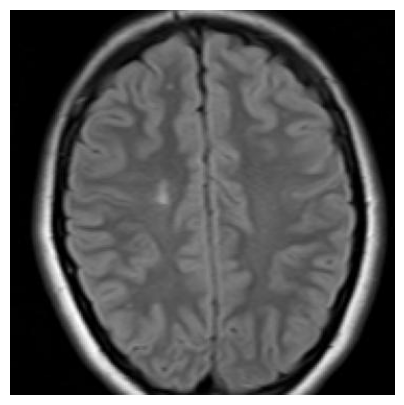

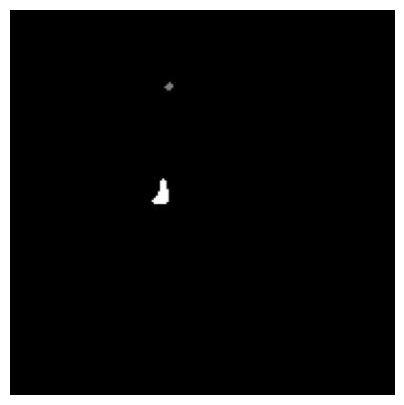

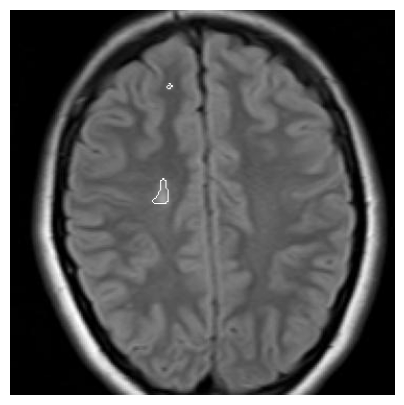

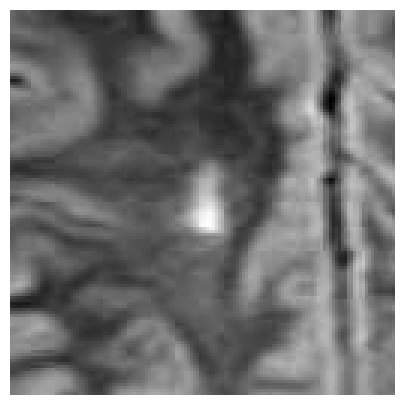

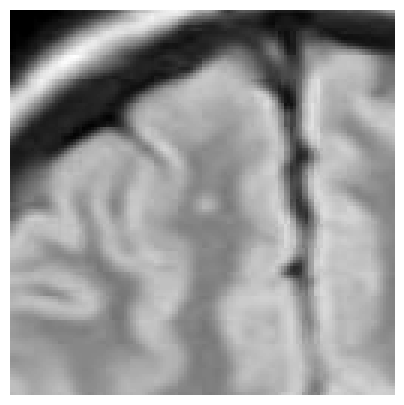

In [12]:
example_img_path =  '14_TWOLESIONS_slice_014.jpg'
img = cv2.imread(twolesions_images + os.sep + example_img_path)
mask = cv2.imread(twolesions_mask+ os.sep + example_img_path)
show(img)
show(mask)

img_with_draw_ctour, list_masks = extract_roi_images(img, mask)
show(img_with_draw_ctour)

for i, x in enumerate(list_masks):
    show(x)

## Final functions to automatize convertions

In [15]:
def save_list_roi_images(file_name, list_masks, type_image):
    filename = file_name.replace("slice", "roi") 
    extension = filename.split(".")[1]
    filename = filename.split(".")[0]
    
    save_dir_dict = {
        'ischemia': { 'roi': save_dir_ischemia_roi},
        'demy': { 'roi': save_dir_demy_roi},
        'twolesions': { 'roi': save_dir_twolesions_roi}
    }
    
    save_dir = os.path.join(save_dir_dict[type_image]['roi'], filename)
    
    for i, roi in enumerate(list_masks):
        name = save_dir +'_' + str(i+1) + '.' + extension
        try:
            save_img(name, roi)
        except Exception:
            print('Error saving: ', name)


In [20]:
def create_and_save_rois(type_image):
    folder_dict = {
        'ischemia': {'images': ischemia_images, 'mask': ischemia_mask},
        'demy': {'images': demy_images, 'mask': demy_mask},
        'twolesions': {'images': twolesions_images, 'mask': twolesions_mask}
    }
    
    folder1 = folder_dict[type_image]['images']
    folder2 = folder_dict[type_image]['mask']

    imagenes_folder1 = set(os.listdir(folder1))

    for file_name in imagenes_folder1:
        img_path = folder1 + os.sep + file_name
        mask_path = folder2 + os.sep + file_name
        
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        
        img_with_draw_ctour, list_masks = extract_roi_images(img, mask)
        save_list_roi_images(file_name, list_masks, type_image)


In [21]:
create_and_save_rois( 'twolesions')